# Explore the dataset created from evidence.txt files from MaxQuant

In this notebook I will explore the dataset created from the evidence files from MaxQuant in the script dataset_from_txt.py

## Preliminars

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import seaborn as sns
from regressor_tf.model_rnn import BIRNN
import tensorflow as tf
from scripts.utils import encoded_sequence, int_dataset
from sklearn.model_selection import train_test_split
import sklearn as sk
import scipy
#load the training pdfs
import pickle

In [2]:
#autoreloaa extensions
%load_ext autoreload
%autoreload 2

In [3]:
sys.path.append('../scripts/')

In [4]:
root_path = os.getenv("DATA_DIR")
train_unique = pd.read_pickle(os.path.join(root_path, "two_populations","train_unique_density_most_intense.pkl"))

In [5]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"
# Set memory growth for all available GPUs
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

2024-12-05 16:33:58.417787: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2024-12-05 16:33:58.458806: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:86:00.0 name: Quadro RTX 5000 computeCapability: 7.5
coreClock: 1.815GHz coreCount: 48 deviceMemorySize: 15.74GiB deviceMemoryBandwidth: 417.29GiB/s
2024-12-05 16:33:58.464022: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2024-12-05 16:33:58.562555: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-12-05 16:33:58.614422: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2024-12-05 16:33:58.650266: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10


# Regressor Model

## Mobideep

The training will be done in the main module of mobideep and I'll explore here the training.

### Training Process

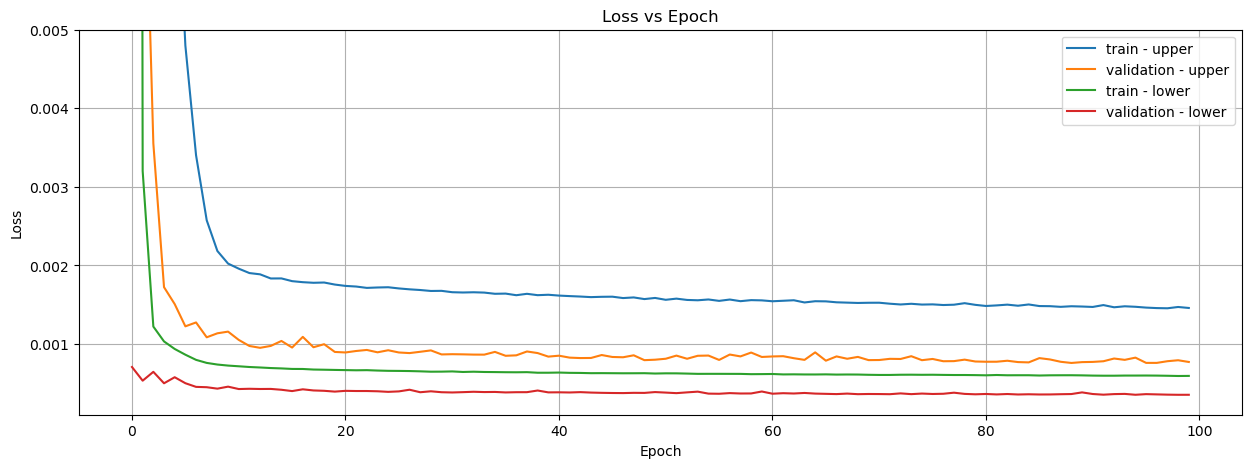

In [10]:
#plot loss
path_to_history = os.path.join(root_path, "..","models", "mobideep", "training_upper_density_most_intense.log")
history = pd.read_csv(path_to_history)

path_to_history = os.path.join(root_path, "..","models", "mobideep", "training_lower_density_most_intense.log")
history_lower = pd.read_csv(path_to_history)

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(history["epoch"],history["loss"], label="train - upper")
ax.plot(history["epoch"],history["val_loss"], label="validation - upper")
ax.plot(history_lower["epoch"],history_lower["loss"], label="train - lower")
ax.plot(history_lower["epoch"],history_lower["val_loss"], label="validation - lower")
ax.legend()
ax.set_ylim([0.0001, 0.005])
ax.set_title("Loss vs Epoch")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
#add grid
ax.grid()

### Eval Set

In [11]:
results = {}
model_params = {
"num_hidden" : 128,
"num_layers" : 2,
"num_classes" : 1,
"embed_dim" : 66,
"dict_size" : 32,
"dropout_rate" : 0.4,  
}


for population in ["lower", "upper"]:
    population_df = train_unique[train_unique["regressor"]==population]

    population_df["encseq"] = encoded_sequence(population_df)
    timesteps = 66
    features = int_dataset(population_df, timesteps, middle=False).squeeze()
    labels = population_df["Mean 1/K0"].values
    X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.1, random_state=42)

    #Function to create a generator for the validation data
    def eval_generator():
        for i in range(len(X_val)):
            yield (X_val[i,:-1], X_val[i,-1]), y_val[i]

    # Define the types and shapes for your dataset
    # Assuming encseq is a variable-length list, charge is a scalar integer, and labels are strings
    types = ((tf.int32, tf.int32), tf.float32)
    shapes = (([66], ()), ())

    # Create the TensorFlow dataset
    dataset_eval = tf.data.Dataset.from_generator(eval_generator, output_types=types, output_shapes=shapes).batch(256)

    model = BIRNN(**model_params)
    model.build(input_shape=[(None, 66), (None, 1)])
    #load in best model
    model_path = os.path.join(root_path, "..", "models", "mobideep")
    model.load_weights(f"{model_path}/checkpoints_{population}_density_most_intense/best")
    #get predictions on validation set
    y_pred = model.predict(dataset_eval)
    y_pred = y_pred.squeeze()
    y_val = y_val.squeeze()

    results[f"{population}"] = {"y_pred": y_pred, "y_val": y_val}

/fs/home/rlopez/.local/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


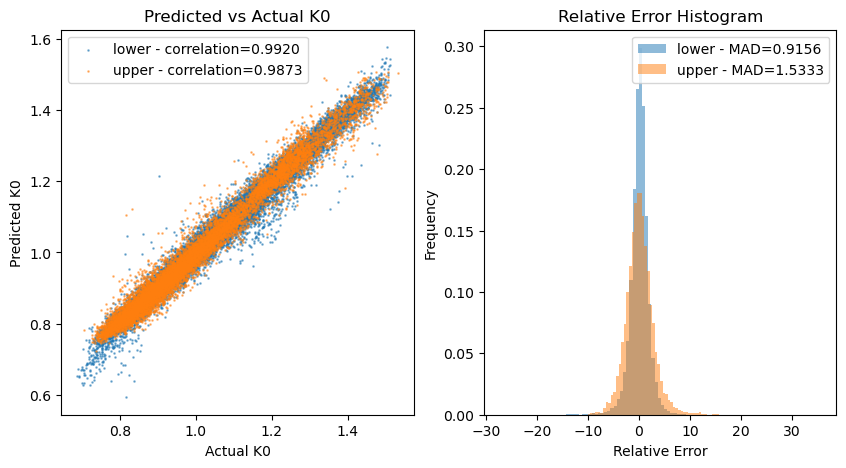

In [12]:
fig, ax = plt.subplots(figsize=(10, 5), nrows=1, ncols=2)

for population, data in results.items():
    y_pred = data["y_pred"]
    y_val = data["y_val"]
    corr = scipy.stats.pearsonr(y_val, y_pred)
    ax[0].scatter(y_val, y_pred, label=f"{population} - correlation={corr[0]:.4f}", s=.8, alpha=0.5)
    ax[0].set_xlabel("Actual K0")
    ax[0].set_ylabel("Predicted K0")
    ax[0].set_title("Predicted vs Actual K0")
    ax[0].legend()

    rel_err = (y_pred - y_val) / y_val * 100
    mad = scipy.stats.median_abs_deviation(rel_err)
    ax[1].hist(rel_err, bins=100, label=f"{population} - MAD={mad:.4f}", alpha=0.5, density=True)
    ax[1].set_xlabel("Relative Error")
    ax[1].set_ylabel("Frequency")
    ax[1].set_title("Relative Error Histogram")
    ax[1].legend()

It looks like our model is indeed learning something useful, power-law results dont look great

### Test Set

In [13]:
from regressor_tf.model_rnn import BIRNN
import scipy

In [14]:
df_test = pd.read_pickle(os.path.join(root_path, "two_populations", "evidence_test_fromRawFiles_2pop.pkl"))

In [15]:
#load the gmms
with open(os.path.join(root_path, "two_populations", "gmms.pkl"), "rb") as f:
    gmms = pickle.load(f)

/fs/home/rlopez/miniconda3/envs/ccs/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/fs/home/rlopez/miniconda3/envs/ccs/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/fs/home/rlopez/miniconda3/envs/ccs/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

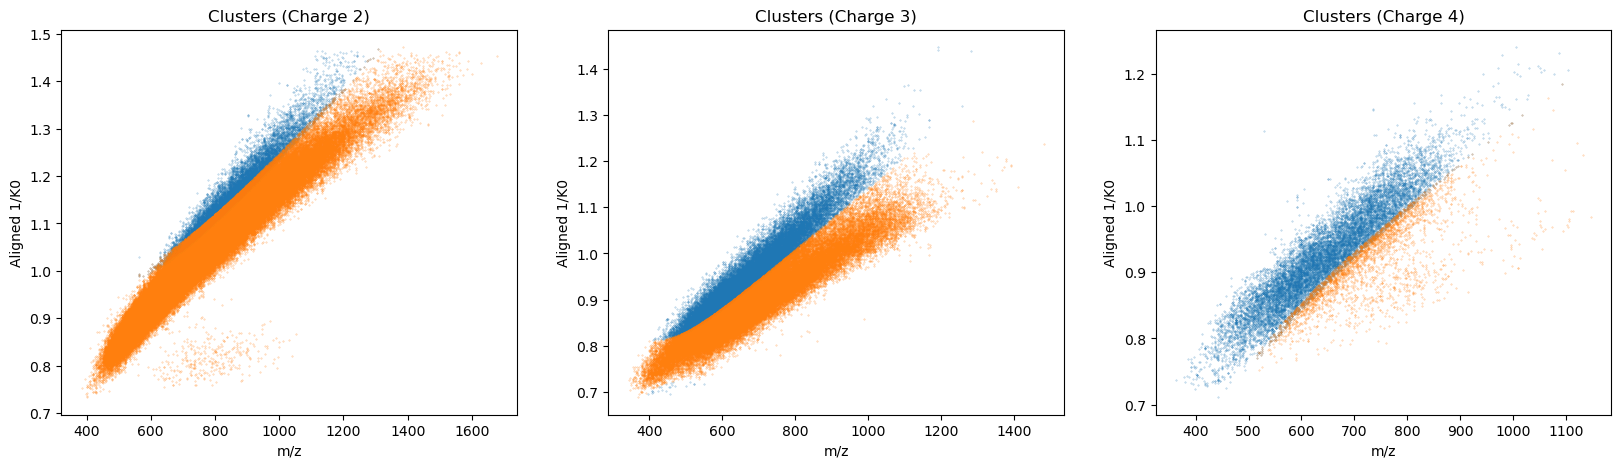

In [16]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(20, 5))
scaler = sk.preprocessing.StandardScaler()
thresholds = {2: 0.3, 3: 0.5, 4: 0.4}

for charge in [2, 3, 4]:
    charge_data = df_test.loc[df_test.Charge == charge,:]
    X_scaled = scaler.fit_transform(charge_data.loc[:,["m/z", "Aligned 1/K0"]])
    gmm = gmms[charge]
    #predict the cluster
    charge_data.loc[:,"prob0"], charge_data.loc[:,"prob1"] = np.hsplit(gmm.predict_proba(X_scaled), 2)
    charge_data.loc[:,"cluster0"] = charge_data.loc[:,"prob0"] >= thresholds[charge] + 0.2
    charge_data.loc[:,"cluster1"] = charge_data.loc[:,"prob1"] >= thresholds[charge] - 0.2
    #update evidence with cluster information
    df_test.loc[charge_data.index, "cluster0"] = charge_data.loc[:,"cluster0"]
    df_test.loc[charge_data.index, "cluster1"] = charge_data.loc[:,"cluster1"]
    # Plot the cluster labels
    #plot the two clusters
    for cluster in ["cluster0", "cluster1"]:
        mask = (df_test.loc[:,cluster]) & (df_test.loc[:,"Charge"] == charge)
        ax[charge-2].scatter(df_test.loc[mask, "m/z"], df_test.loc[mask, "Aligned 1/K0"], s=0.1, label=f"cluster {cluster}", alpha=0.5)
    ax[charge-2].set_xlabel("m/z")
    ax[charge-2].set_ylabel("Aligned 1/K0")
    ax[charge-2].set_title(f"Clusters (Charge {charge})")

In [15]:
###### TAKE THE MEAN

"""
#take only the cluster 1 (upper)
cluster_up = df_test[df_test["cluster0"]]
#sort by modified sequence and charge and intensity
mean_df = cluster_up.groupby(["Modified sequence", "Charge"])["Aligned 1/K0"].mean().reset_index(name="Mean 1/K0")
#merge the original DataFrame with the grouped DataFrame
cluster_up = pd.merge(cluster_up, mean_df, on=["Modified sequence", "Charge"], how="inner")
cluster_up["regressor"] = "upper"

#take only the cluster 0 (lower)
cluster_low = df_test[df_test["cluster1"]]
#group by modified sequence and charge and get the mean of the aligned 1/K0
mean_df = cluster_low.groupby(["Modified sequence", "Charge"])["Aligned 1/K0"].mean().reset_index(name="Mean 1/K0")
#merge the original DataFrame with the grouped DataFrame
cluster_low = pd.merge(cluster_low, mean_df, on=["Modified sequence", "Charge"], how="inner")
cluster_low["regressor"] = "lower"

#concatenate the two DataFrames
test_avg = pd.concat([cluster_up, cluster_low])
"""

In [17]:
###### TAKE THE MOST INTENSE FEATURE


#take only the cluster 1 (upper)
cluster_up = df_test[df_test["cluster0"]]
#sort by modified sequence and charge and intensity
#take the most intense feature
first_up = cluster_up.sort_values(by=["Modified sequence", "Charge", "Intensity"], ascending=False).groupby(["Modified sequence", "Charge"]).first().reset_index()
first_up["regressor"] = "upper"

#take only the cluster 0 (lower)
cluster_low = df_test[df_test["cluster1"]]
#take the most intense feature
first_low = cluster_low.sort_values(by=["Modified sequence", "Charge", "Intensity"], ascending=False).groupby(["Modified sequence", "Charge"]).first().reset_index()
first_low["regressor"] = "lower"

#concatenate the two DataFrames
test_avg = pd.concat([first_up, first_low])

test_avg["Mean 1/K0"] = test_avg["Aligned 1/K0"]

In [18]:
#get the precursors of df_test that are not in train_unique
#precursors are the tuples (Modidied sequence, charge)
test_set = set(tuple(x) for x in test_avg[["Modified sequence", "Charge"]].values)
precursors = test_set.copy()
#conver to list
precursors = list(precursors)

In [19]:
train_set = set(tuple(x) for x in train_unique[["Modified sequence", "Charge"]].values)

In [20]:
precursors = [x for x in precursors if x not in train_set]

In [21]:
print(f"Number of precursors not in train_unique: {len(precursors)}")
print(f"Number of precursors in df_test: {len(test_set)}")
print(f"Number of precursors in train_unique: {len(train_set)}")

Number of precursors not in train_unique: 167846
Number of precursors in df_test: 221820
Number of precursors in train_unique: 573196


In [22]:
# My code here
mod_seq = [x[0] for x in precursors]
charge = [x[1] for x in precursors]
df_test_unique = test_avg[test_avg["Modified sequence"].isin(mod_seq) & test_avg["Charge"].isin(charge)]

In [23]:
#group df_test_unique by modified sequence and charge and take the row with the highest intensity
df_test_unique = df_test_unique.sort_values("Intensity", ascending=False).groupby(
    ["Modified sequence", "Charge"]).first().reset_index()

In [24]:
print(f"Number of precursors in df_test_unique: {len(df_test_unique)}")
df_test_unique.head()

Number of precursors in df_test_unique: 171368


,Modified sequence,Charge,Sequence,Length,Modifications,Oxidation (M) Probabilities,Oxidation (M) Score Diffs,Acetyl (Protein N-term),Oxidation (M),Missed cleavages,...,Oxidation (M) site IDs,Taxonomy IDs,Taxonomy names,Mass deficit,median_delta,Aligned 1/K0,cluster0,cluster1,regressor,Mean 1/K0
0,_(ac)AAAAAAAAEQQSSNGPVKK_,2,AAAAAAAAEQQSSNGPVKK,19,Acetyl (Protein N-term),None,None,1,0,1,...,None,9606.0,Homo sapiens,0.044318,-0.006516,1.206691,True,False,upper,1.206691
1,_(ac)AAAAAETPEVLRECGCK_,2,AAAAAETPEVLRECGCK,17,Acetyl (Protein N-term),None,None,1,0,1,...,None,9606.0,Homo sapiens,-0.035746,-0.004529,1.209502,True,False,upper,1.209502
2,_(ac)AAAAALRAPAQVVGM(ox)EGK_,2,AAAAALRAPAQVVGMEGK,18,"Acetyl (Protein N-term),Oxidation (M)",AAAAALRAPAQVVGM(1)EGK,AAAAALRAPAQVVGM(42)EGK,1,1,1,...,8812,9606.0,Homo sapiens,0.076905,-0.006794,1.175614,True,False,upper,1.175614
3,_(ac)AAAGQEKGYLTQTAAALDK_,2,AAAGQEKGYLTQTAAALDK,19,Acetyl (Protein N-term),None,None,1,0,1,...,None,9606.0,Homo sapiens,0.054095,-0.014387,1.201647,False,True,lower,1.201647
4,_(ac)AAAGSRETPLNQESAR_,2,AAAGSRETPLNQESAR,16,Acetyl (Protein N-term),None,None,1,0,1,...,None,9606.0,Homo sapiens,0.007063,0.024817,1.097687,False,True,lower,1.097687


In [25]:
df_test_unique["encseq"] = encoded_sequence(df_test_unique)
timesteps = 66
features = int_dataset(df_test_unique, timesteps, middle=False).squeeze()
labels = df_test_unique["Mean 1/K0"].values

In [31]:
model_params = {
"num_hidden" : 128,
"num_layers" : 2,
"num_classes" : 1,
"embed_dim" : 66,
"dict_size" : 32,
"dropout_rate" : 0.4,  
}

In [32]:
model_dict = {}

In [33]:
for population in ["upper", "lower"]:
    model = BIRNN(**model_params)
    model.build(input_shape=[(None, 66), (None, 1)])
    #load in best model
    model_path = os.path.join(root_path, "..", "models", "mobideep")
    model.load_weights(f"{model_path}/checkpoints_{population}_density_most_intense/best")
    model_dict[population] = model

In [34]:
def test_generator():
    for i in range(len(features)):
        yield (features[i,:-1], features[i,-1]), labels[i]

# Define the types and shapes for your dataset
# Assuming encseq is a variable-length list, charge is a scalar integer, and labels are strings
types = ((tf.int32, tf.int32), tf.float32)
shapes = (([66], ()), ())
# Create the TensorFlow dataset
dataset_test = tf.data.Dataset.from_generator(test_generator, output_types=types, output_shapes=shapes).batch(256)

In [35]:
y_pred_upper = model_dict["upper"].predict(dataset_test).squeeze()
y_pred_lower = model_dict["lower"].predict(dataset_test).squeeze()

In [36]:
df_test_unique["Predicted K0 upper"] = y_pred_upper
df_test_unique["Predicted K0 lower"] = y_pred_lower

In [41]:
#choose the preiction with the highest pdf
#y_pred = np.where(df_test_unique["pdf_upper"] > df_test_unique["pdf_lower"], df_test_unique["Predicted K0 upper"], df_test_unique["Predicted K0 lower"])

In [37]:
#choose the best prediction as the one closest to label
y_pred = np.where(np.abs(y_pred_upper - labels) < np.abs(y_pred_lower - labels), y_pred_upper, y_pred_lower)

In [38]:
y_test = labels

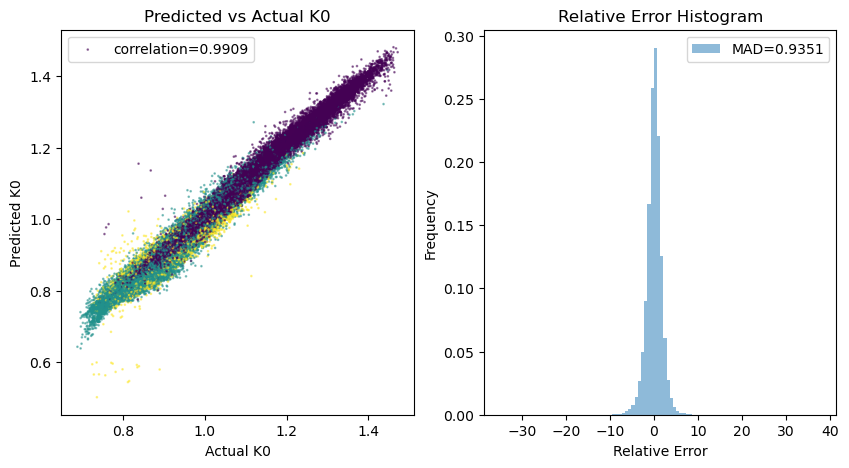

In [39]:
#plot the distribution of the relative errors and the correlation between the predicted and true values
fig, ax = plt.subplots(figsize=(10, 5), nrows=1, ncols=2)

corr = scipy.stats.pearsonr(y_test, y_pred)
ax[0].scatter(y_test, y_pred, label=f"correlation={corr[0]:.4f}", s=.8, alpha=0.5, c=features[:,-1])
ax[0].set_xlabel("Actual K0")
ax[0].set_ylabel("Predicted K0")
ax[0].set_title("Predicted vs Actual K0")
ax[0].legend()

rel_err = (y_pred - y_test) / y_test * 100
mad = scipy.stats.median_abs_deviation(rel_err)
ax[1].hist(rel_err, bins=100, label=f"MAD={mad:.4f}", alpha=0.5, density=True)
ax[1].set_xlabel("Relative Error")
ax[1].set_ylabel("Frequency")
ax[1].set_title("Relative Error Histogram")
ax[1].legend()


In [40]:
rel_err[rel_err > 15]

array([15.32615074, 28.68708505, 25.4139872 , 25.54353268, 37.78973876,
       16.37044601, 17.85115478, 28.87980063, 17.28152846, 15.46046898,
       17.61451263, 17.76321216, 19.48513491, 17.29792374, 30.86808545,
       18.12566962, 17.03532962, 20.32027267, 21.81697506, 15.60941193,
       16.47100271, 17.32382797, 26.92180462, 17.94410674])